# Configuration.
Enter the paths to the file containting the validation data and the path to the builderConnectivityRecipeAllPathways.xml used.

The validation data is obtained using the "validate_bouton_density.py" or "validate_syns_con.py" scripts.
Please also specify the modality of the validation data: "syns_con" or "bouton_density"

In [12]:
fn = "/home/reimann/Documents/data/SSCX/validation/Bio_0/post-morphology_update/bd_result_central_column_4_regions.csv"
fn_recipe = "/home/reimann/Documents/data/SSCX/validation/Bio_0/post-adjustment1/builderConnectivityRecipeAllPathways.xml"
#data_modality = "syns_con"
data_modality = "bouton_density"


Here, we configure some things that differ depending on the modality of the data.

In [13]:
if data_modality == "syns_con":
    lo_key = "from"
    recipe_set_key = "mean_syns_connection"
    min_val = 1.0
    max_val = 1E20
    plt_label = "Synapses per connection"
elif data_modality == "bouton_density":
    lo_key = "mtype"
    recipe_set_key = "bouton_reduction_factor"
    min_val = 0.0
    max_val = 1.0
    plt_label = "Bouton density (/um)"

# Read data
We import required packages and read in the data.
We also define a convenience function that determines if an m-type is excitatory or inhibitory. 
This serves plotting purposes, so we can plot data for exc. and inh. types separately. This function was written
for SSCX or mouse neocortex circuits, for other models you might have to update!

In [14]:
import pandas
import numpy
from matplotlib import pyplot as plt

data = pandas.read_csv(fn)
data = data.loc[~numpy.isnan(data['Error'])]
display(data)

def mtype_is_excitatory(str_m):
    if "PC" in str_m:
        return True
    if "SSC" in str_m:
        return True
    return False

,mtype,Mean (data),Std (data),Mean (ref.),Std (ref.),Samples (data),Error
0,*,0.1920,0.0585,0.1914,0.06379,"0.031,0.0348,0.0521,0.0627,0.0715,0.0728,0.076...",0.981274
1,L1_DAC,0.1710,0.0760,0.1824,0.02527,"0.0331,0.043,0.0434,0.0453,0.0481,0.0491,0.049...",-22.514071
2,L1_HAC,0.1930,0.1090,0.1997,0.04176,"0.021,0.0215,0.0219,0.0221,0.0236,0.0241,0.024...",-8.888299
3,L1_LAC,0.2220,0.1050,0.2200,0.01001,"0.00961,0.0108,0.0182,0.0302,0.0339,0.0373,0.0...",3.477958
4,L1_NGC-DA,0.1800,0.0998,0.2017,0.04812,"0.0137,0.0172,0.0189,0.0216,0.0241,0.0246,0.02...",-29.340184
5,L1_NGC-SA,0.1780,0.0937,0.1850,0.04766,"0.00118,0.00737,0.00884,0.00941,0.0128,0.0151,...",-9.903792
6,L1_SAC,0.1680,0.0858,0.1837,0.05502,"0.0107,0.0206,0.0211,0.0231,0.0284,0.0305,0.03...",-22.297969
7,L23_BP,0.2010,0.0412,0.1861,0.00000,"0.117,0.118,0.118,0.12,0.123,0.124,0.125,0.127...",72.330097
8,L23_BTC,0.2050,0.0511,0.2020,0.03921,"0.106,0.115,0.115,0.115,0.119,0.128,0.128,0.12...",6.643783
9,L23_CHC,0.0668,0.0174,0.2318,0.04466,"0.0427,0.0472,0.0487,0.049,0.0498,0.0501,0.050...",-531.743474


# Plot results: Comparison to reference

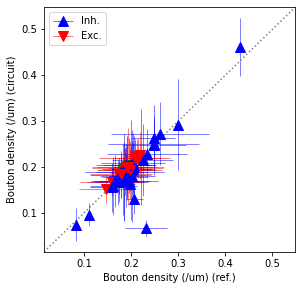

In [15]:
fig = plt.figure(figsize=(4.5, 4.5))
ax = fig.gca()
lbl_e = "Exc."; lbl_i = "Inh."

for i, row in data.iterrows():
    if i == 0:
        col = "green"
        marker = "o"
        ms = 20
        label=None
    elif mtype_is_excitatory(row[lo_key]):
        col = "red"
        marker = "v"
        ms = 10
        label=lbl_e
        lbl_e = None
    else:
        col = "blue"
        marker = "^"
        ms = 10
        label=lbl_i
        lbl_i = None
    ax.errorbar(row["Mean (ref.)"], row["Mean (data)"], xerr=row["Std (ref.)"], yerr=row["Std (data)"],
               color=col, marker=marker, ms=ms, lw=0.5, label=label)

lims = numpy.vstack([ax.get_xlim(), ax.get_ylim()])
lims = [numpy.min(lims[:, 0]), numpy.max(lims[:, 1])]
ax.set_xlim(lims); ax.set_ylim(lims)
ax.plot(lims, lims, color='grey', ls=":")
ax.set_xlabel(plt_label + " (ref.)")
ax.set_ylabel(plt_label + " (circuit)")
plt.legend()

# Plot results: Relative error

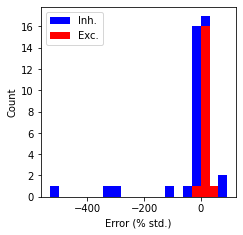

In [7]:
error_bins = numpy.linspace(numpy.nanmin(data["Error"]),
                            numpy.nanmax(data["Error"]), 21)
bin_centers = 0.5 * (error_bins[:-1] + error_bins[1:])
w = error_bins[1] - error_bins[0]
lbl_e = "Exc."; lbl_i = "Inh."

is_exc = data[lo_key].apply(mtype_is_excitatory)
H_exc = numpy.histogram(data["Error"][is_exc], bins=error_bins)[0]
H_inh = numpy.histogram(data["Error"][~is_exc], bins=error_bins)[0]

fig = plt.figure(figsize=(3.5, 3.5))
ax = fig.gca()

for x, y1, y2 in zip(bin_centers, H_exc, H_inh):
    if y1 > y2:
        ax.bar(x, y1, color='red', width=w, label=lbl_e)
        ax.bar(x, y2, color='blue', width=w, label=lbl_i)
    else:
        ax.bar(x, y2, color='blue', width=w, label=lbl_i)
        ax.bar(x, y1, color='red', width=w, label=lbl_e)
    lbl_e = None; lbl_i = None

ax.set_xlabel("Error (% std.)")
ax.set_ylabel("Count")
plt.legend()